In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches
from scarches.models import TRANVAE
from scarches.dataset import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.set_figure_params(dpi=100)

In [4]:
batch_key = 'condition'
cell_type_key = 'final_annotation'

tranvae_epochs = 500
target_batches = []
n_labelled_samples_per_class = 5

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [5]:
# Save right dir path
dir_path = os.path.expanduser(f'~/Documents/tranvae/pbmc_semi_full/')
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
control_path = f'{dir_path}controlling/'
if not os.path.exists(control_path):
    os.makedirs(control_path)

In [6]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/Immune_ALL_human_wo_villani_rqr_normalized_hvg.h5ad'))
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)

In [7]:
query = np.array([s in target_batches for s in adata.obs[batch_key]])
adata_ref = adata[~query].copy()

In [8]:
adata_ref

AnnData object with n_obs × n_vars = 20522 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [9]:
un_labels_r = adata_ref.obs[cell_type_key].unique().tolist()
un_labels_r

['CD16+ Monocytes',
 'HSPCs',
 'CD8+ T cells',
 'Erythrocytes',
 'CD10+ B cells',
 'Plasmacytoid dendritic cells',
 'Monocyte progenitors',
 'CD20+ B cells',
 'Monocyte-derived dendritic cells',
 'Plasma cells',
 'Erythroid progenitors',
 'Megakaryocyte progenitors',
 'NK cells',
 'NKT cells',
 'CD14+ Monocytes',
 'CD4+ T cells']

In [10]:
labeled_ind = []
unlabeled_ind = []
for label in un_labels_r:
    mask = adata_ref.obs[cell_type_key] == label
    mask = mask.tolist()
    idx = np.where(mask)[0]
    np.random.shuffle(idx)
    labeled_ind += idx[:n_labelled_samples_per_class].tolist()
    unlabeled_ind += idx[n_labelled_samples_per_class:].tolist()

print(len(labeled_ind))
print(len(unlabeled_ind))

80
20442


In [11]:
trvae = scarches.models.TRVAE(
    adata=adata_ref,
    condition_key=batch_key,
    hidden_layer_sizes=[128, 128],
    use_mmd=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [12]:
trvae.train(
    n_epochs=500,
    alpha_epoch_anneal=100,
    early_stopping_kwargs=early_stopping_kwargs,
)

 |███-----------------| 19.0%  - epoch_loss: 3336.30 - epoch_recon_loss: 3326.18 - epoch_kl_loss:   10.77 - val_loss: 4390.36 - val_recon_loss: 4380.20 - val_kl_loss:   10.81
ADJUSTED LR
 |████----------------| 24.0%  - epoch_loss: 3377.86 - epoch_recon_loss: 3367.41 - epoch_kl_loss:   10.45 - val_loss: 4203.99 - val_recon_loss: 4193.18 - val_kl_loss:   10.81
ADJUSTED LR
 |█████---------------| 25.4%  - epoch_loss: 3354.50 - epoch_recon_loss: 3344.06 - epoch_kl_loss:   10.44 - val_loss: 4189.30 - val_recon_loss: 4178.30 - val_kl_loss:   10.99
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 105


In [13]:
tranvae = scarches.models.TRANVAE(
    adata=adata_ref,
    condition_key=batch_key,
    cell_type_key=cell_type_key,
    labeled_indices=labeled_ind,
    hidden_layer_sizes=[128, 128],
    use_mmd=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [14]:
tranvae.model.load_state_dict(trvae.model.state_dict())

<All keys matched successfully>

In [15]:
tranvae.train(
    n_epochs=tranvae_epochs,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=1000,
    tau=0,
)

 |██------------------| 10.6%  - epoch_loss: 3479.62 - epoch_trvae_loss: 3389.71 - epoch_classifier_loss:   89.91 - epoch_unlabeled_loss:    0.06 - epoch_labeled_loss:    0.03 - val_loss: 5169.07 - val_trvae_loss: 4176.21 - val_classifier_loss:  992.86 - val_unlabeled_loss:    0.16 - val_labeled_loss:    0.84
ADJUSTED LR
 |██------------------| 12.0%  - epoch_loss: 3459.83 - epoch_trvae_loss: 3390.36 - epoch_classifier_loss:   69.46 - epoch_unlabeled_loss:    0.05 - epoch_labeled_loss:    0.02 - val_loss: 4621.41 - val_trvae_loss: 4094.12 - val_classifier_loss:  527.29 - val_unlabeled_loss:    0.13 - val_labeled_loss:    0.40
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 38


In [16]:
print("Acc: {}".format(np.mean(tranvae.classify() == adata_ref.obs[cell_type_key].tolist())))

Acc: 0.7260500925835689


In [17]:
latent_ref = sc.AnnData(tranvae.get_latent())
latent_ref.obs['celltype'] = adata_ref.obs[cell_type_key].tolist()
latent_ref.obs['batch'] = adata_ref.obs[batch_key].tolist()
latent_ref.obs['predictions'] = tranvae.classify()

In [18]:
sc.pp.neighbors(latent_ref, n_neighbors=8)
sc.tl.leiden(latent_ref)
sc.tl.umap(latent_ref)
latent_ref.write_h5ad(filename=f'{dir_path}reference_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


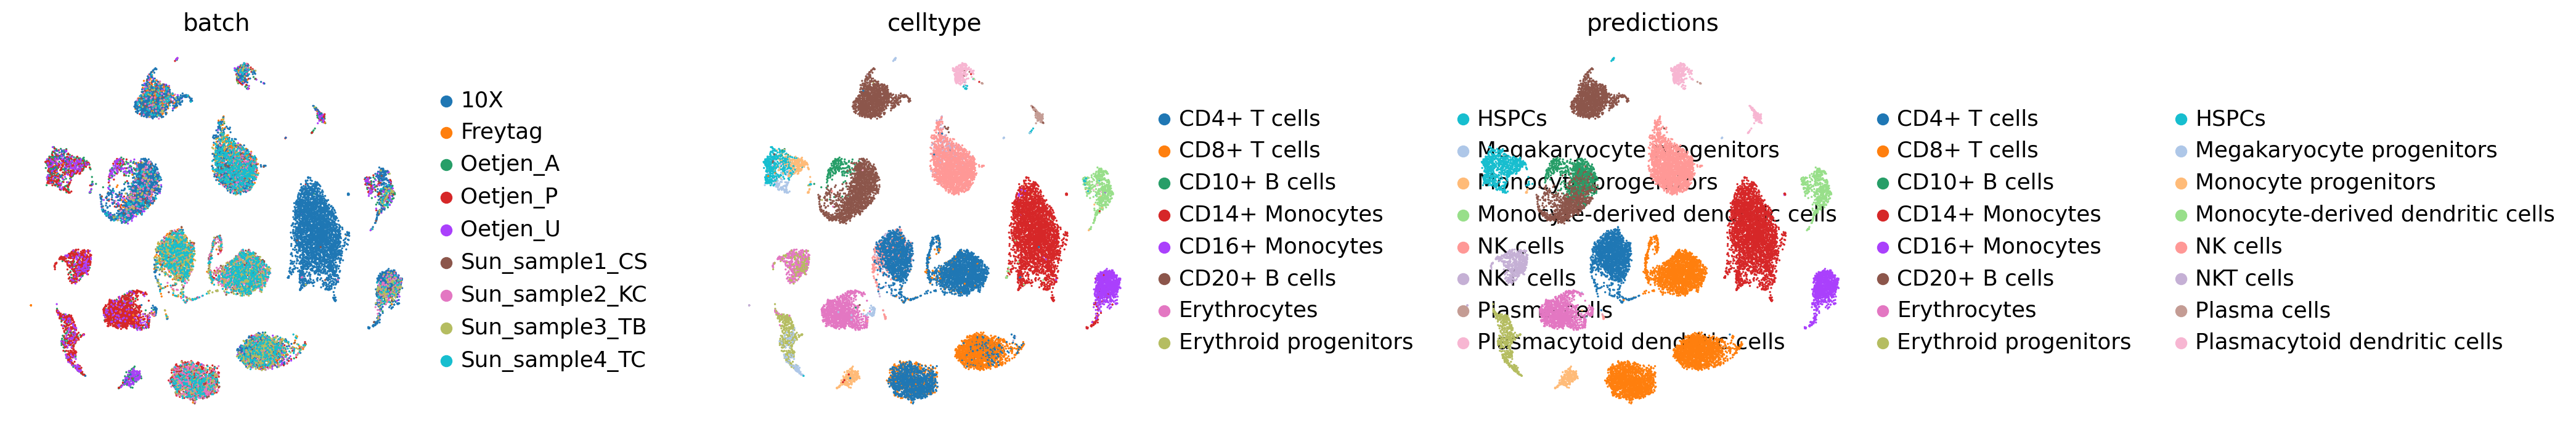

In [19]:
sc.pl.umap(latent_ref,
           color=['batch', 'celltype', 'predictions'],
           frameon=False,
           wspace=0.6,
           show=False,
           )
plt.savefig(f"{control_path}umaps.pdf", bbox_inches='tight')

In [20]:
ref_path = f'{dir_path}reference_model/'
tranvae.save(ref_path, overwrite=True)